<a href="https://colab.research.google.com/github/Lexaun-chen/STAT-4830-Group-Project/blob/main/notebooks/Demo_Expedia_Adam_Matrix_Completion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === Core Libraries ===
import numpy as np
import pandas as pd
import math

# === PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Scikit-learn ===
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available:", device)
    torch.cuda.init()
else:
    device = torch.device("cpu")
    print("GPU unavailable: CPU")

GPU available: cuda


In [3]:
class Sales:
    def __init__(self, all_offer_sets, sell_num, mask):
        self.offer_set_list = []
        self.fw = None
        self.scores = None
        self.N_sales = torch.tensor(np.concatenate(sell_num, axis=1), dtype=torch.float64, device=device)
        self.offer_feature = torch.tensor(all_offer_sets, dtype=torch.float64)
        self.original_shape = self.offer_feature.shape
        self.feature_concat = self.offer_feature.reshape(-1, self.offer_feature.shape[2]).to(device)
        self.N = len(all_offer_sets)
        self.mask = torch.tensor(mask, dtype=torch.float64, device=device)
        self.mask_flat = self.mask.reshape((-1,))
        self.masked_feature_concat = self.feature_concat[self.mask_flat == 1]

    def calculate_all_choice_prob(self, W):
        rule_feature = self.feature_concat
        self.fw = self.calculate_choice_prob(rule_feature, W)
        return self.fw

    def calculate_choice_prob(self, rule_feature, W):
        Z = W(rule_feature).reshape(self.original_shape[:2])
        masked_Z = Z.masked_fill(self.mask == 0, float('-inf'))
        softmax_result = F.softmax(masked_Z, dim=-1).reshape((-1, 1))[self.mask_flat == 1]
        return softmax_result

    def calculate_all_choice_score(self, W):
        rule_feature = self.feature_concat
        self.scores = self.calculate_choice_score(rule_feature, W)
        return self.scores

    def calculate_choice_score(self, rule_feature, W):
        Z = W(rule_feature).reshape(self.original_shape[:2])
        masked_Z = Z.masked_fill(self.mask == 0, float('-inf'))
        raw_scores = masked_Z.reshape((-1, 1))[self.mask_flat == 1]
        return raw_scores

In [4]:
class Deep_MNL(nn.Module):
    def __init__(self, input_dim):
        super(Deep_MNL, self).__init__()
        self.layer1 = nn.Linear(input_dim, 100, dtype=torch.float64, bias=False).to(device)
        self.layer2 = nn.Linear(100, 100, dtype=torch.float64, bias=False).to(device)
        self.layer3 = nn.Linear(100, 1, dtype=torch.float64, bias=False).to(device)

    def _initialize_weights(self):
        nn.init.constant_(self.layer1.weight, 0)
        nn.init.constant_(self.layer1.bias, 0)
        nn.init.constant_(self.layer2.weight, 0)
        nn.init.constant_(self.layer2.bias, 0)
        nn.init.constant_(self.layer3.weight, 0)
        nn.init.constant_(self.layer3.bias, 0)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.sigmoid(x)
        x = self.layer2(x)
        x = torch.sigmoid(x)
        x = self.layer3(x)
        return x

In [5]:
class Problem_MNL:
    def __init__(self, S, N, M): #Option set, Number of sales, Mask
        self.W = None
        self.sales = Sales(S, N, M)
        # Define and initialize the ruleset
        self.feature_num = S.shape[-1]
        # Put the feature to the GPU
        self.sales.feature_concat = self.sales.feature_concat.to(device)
        # Define a consumer list that contain consumer types
        self.consumer_list = []
        # Define the main problem NLL loss
        self.NLL_main = None
        # Define the current likelihood convex combination
        self.g = None
        # Define the current likelihood gradient for support finding
        self.NLL_gradient = None
        # Define a list to contain all fw choice likelihood
        self.fw_list = []
        # Define a new sales data for further estimation
        self.sales_estimate = None

    def loss(self, W):
        N = self.sales.N
        N_sales = self.sales.N_sales
        normalize_term = torch.tensor(1 / N, dtype=torch.float64, device=device)
        fw = self.sales.calculate_all_choice_prob(W)
        fw_log = torch.log(fw)
        return -normalize_term * torch.matmul(N_sales, fw_log)

    def optimize_w(self):
        input_dim = tr_offerset_list.shape[-1]
        encoder = Deep_MNL(input_dim=input_dim).to(device)  # Move the entire model to the device
        self.W = encoder
        loss_previous = 1e10000
        optimizer = optim.Adam(encoder.parameters(), lr=3e-5, weight_decay=1e-7)
        optimizer.zero_grad()
        NLL_list = []
        epoches = 3000
        test_loss_list = []

        loss_previous = float('inf')
        early_stop_count = 0
        patience = 20

        for epoch in range(epoches):
            LOSS = self.loss(encoder)
            LOSS.backward()
            optimizer.step()
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{epoches}], Loss: {LOSS.item():.4f}')
            loss_current = LOSS.item()

            if loss_current < loss_previous - 1e-4:
                loss_previous = loss_current
                early_stop_count = 0
            else:
                early_stop_count += 1
                if early_stop_count >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

            NLL_list.append(loss_current)
            test_loss = self.estimate(te_offerset_list, te_sell_list, te_mask_list)
            test_loss_list.append(test_loss.item())

        return NLL_list, test_loss_list


    def estimate(self, S, N, M):
        sales_estimate = Sales(S, N, M)
        N = sales_estimate.N
        N_sales = sales_estimate.N_sales
        normalize_term = torch.tensor(1 / N, dtype=torch.float64, device=device)
        fw = sales_estimate.calculate_all_choice_prob(self.W)
        fw_log = torch.log(fw)
        return -normalize_term * torch.matmul(N_sales, fw_log)

In [6]:
def get_offer_data(data_grouped, max_num=32):
    offerset_list = []
    sell_list = []
    mask_list = []
    meta_list = []

    for srch_id, group in data_grouped:
        num_product = len(group)

        # Store metadata (srch_id, prop_id)
        prop_ids = group['prop_id'].values
        meta_list.extend([(srch_id, pid) for pid in prop_ids])

        # Prepare features excluding prop_id
        offerset = group.drop(columns=['booking_bool', 'srch_id', 'prop_id']).values
        offer_dummy = np.zeros((max_num - num_product, offerset.shape[1]))
        offerset = np.vstack((offerset, offer_dummy))

        # Mask and label
        offer_mask = np.append(np.ones(num_product), np.zeros(max_num - num_product))
        num_sell = group['booking_bool'].values.reshape(1, -1)

        offerset_list.append(offerset)
        sell_list.append(num_sell)
        mask_list.append(offer_mask)

    offerset_list = np.array(offerset_list)
    mask_list = np.array(mask_list)

    return offerset_list, sell_list, mask_list, meta_list


search_info = ['srch_id']
feature = [ 'prop_id','prop_starrating',
           'prop_location_score1', 'prop_log_historical_price',
           'prop_brand_bool', 'promotion_flag', 'srch_booking_window', 'srch_length_of_stay',
           'srch_adults_count', 'srch_children_count', 'srch_room_count',
           'srch_saturday_night_bool', 'price_usd',  'booking_bool']


# tr_data = pd.read_csv('train7000.csv')
# te_data = pd.read_csv('test1000.csv')
tr_df = pd.read_csv("https://raw.githubusercontent.com/Lexaun-chen/STAT-4830-Group-Project/main/tests/train7000.csv")
te_df = pd.read_csv("https://raw.githubusercontent.com/Lexaun-chen/STAT-4830-Group-Project/main/tests/test1000.csv")
tr_data = tr_df[search_info + feature]
te_data = te_df[search_info + feature]
tr_offerset_list, tr_sell_list, tr_mask_list, _ = get_offer_data(tr_data.groupby('srch_id'))
te_offerset_list, te_sell_list, te_mask_list, _ = get_offer_data(te_data.groupby('srch_id'))


Epoch [10/3000], Loss: 3.2553
Epoch [20/3000], Loss: 3.2551
Epoch [30/3000], Loss: 3.2549
Epoch [40/3000], Loss: 3.2547
Epoch [50/3000], Loss: 3.2544
Epoch [60/3000], Loss: 3.2542
Epoch [70/3000], Loss: 3.2539
Epoch [80/3000], Loss: 3.2536
Epoch [90/3000], Loss: 3.2533
Epoch [100/3000], Loss: 3.2530
Epoch [110/3000], Loss: 3.2527
Epoch [120/3000], Loss: 3.2524
Epoch [130/3000], Loss: 3.2521
Epoch [140/3000], Loss: 3.2518
Epoch [150/3000], Loss: 3.2514
Epoch [160/3000], Loss: 3.2511
Epoch [170/3000], Loss: 3.2508
Epoch [180/3000], Loss: 3.2504
Epoch [190/3000], Loss: 3.2501
Epoch [200/3000], Loss: 3.2498
Epoch [210/3000], Loss: 3.2494
Epoch [220/3000], Loss: 3.2491
Epoch [230/3000], Loss: 3.2488
Epoch [240/3000], Loss: 3.2484
Epoch [250/3000], Loss: 3.2481
Epoch [260/3000], Loss: 3.2478
Epoch [270/3000], Loss: 3.2474
Epoch [280/3000], Loss: 3.2471
Epoch [290/3000], Loss: 3.2467
Epoch [300/3000], Loss: 3.2464
Epoch [310/3000], Loss: 3.2460
Epoch [320/3000], Loss: 3.2457
Epoch [330/3000],

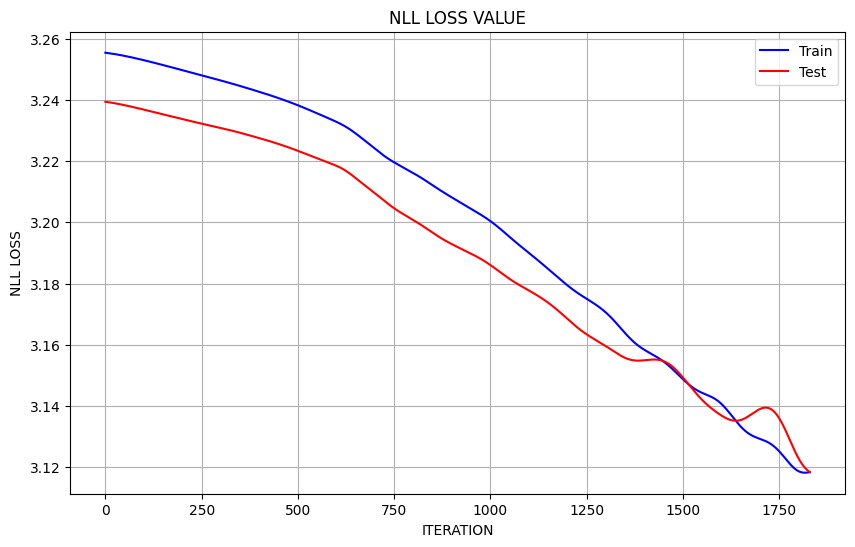

In [7]:
def train_MNL():
    problem = Problem_MNL(tr_offerset_list, tr_sell_list, tr_mask_list)
    NLL_list, NLL_LIST_TEST = problem.optimize_w()
    return problem, NLL_list, NLL_LIST_TEST

MNL_problem, NLL_LIST,NLL_LIST_TEST = train_MNL()
plt.figure(figsize=(10, 6))
plt.plot(NLL_LIST, linestyle='-', color='b', label='Train')
plt.plot(NLL_LIST_TEST, linestyle='-', color='r', label='Test')
plt.title('NLL LOSS VALUE')
plt.xlabel('ITERATION')
plt.ylabel('NLL LOSS')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
torch.save(MNL_problem.W.state_dict(), 'deep_mnl_model_depth2_100.pth')

In [10]:
def build_sparse_prediction_matrix(score_tensor, meta_list, mask_list):
    """
    Constructs a sparse matrix of predicted choice probabilities.

    Args:
        fw_tensor (Tensor): The output from calculate_all_choice_prob(W), shape = (#non-padding, 1)
        meta_list (list of tuples): List of (srch_id, prop_id) in the same order as fw

    Returns:
        sparse_matrix (coo_matrix): Sparse matrix [srch_id_idx, prop_id_idx] = probability
        srch_df (DataFrame): Mapping from matrix row index to original srch_id
        prop_df (DataFrame): Mapping from matrix col index to original prop_id
    """
    # Convert fw to numpy
    score = score_tensor.detach().cpu().numpy().flatten()

    srch_ids, prop_ids = zip(*meta_list)
    srch_encoder = LabelEncoder()
    prop_encoder = LabelEncoder()
    srch_indices = srch_encoder.fit_transform(srch_ids)
    prop_indices = prop_encoder.fit_transform(prop_ids)

    # Construct a zero-sum matrix and fill it with probability values
    num_srch = len(srch_encoder.classes_)
    num_prop = len(prop_encoder.classes_)
    matrix_full = np.full((num_srch, num_prop), np.nan)

    print(len(score), len(srch_indices), len(prop_indices))
    print(num_srch, num_prop)

    for i in range(len(score)):
        matrix_full[ srch_indices[i], prop_indices[i]] = score[i]


    # Transfer into torch.tensor
    R = torch.tensor(matrix_full, dtype=torch.float32, device=device)

    srch_df = pd.DataFrame({'matrix_col': range(len(srch_encoder.classes_)), 'srch_id': srch_encoder.classes_})  # Column index: srch_id
    prop_df = pd.DataFrame({'matrix_row': range(len(prop_encoder.classes_)), 'prop_id': prop_encoder.classes_})  # Row index: prop_id

    return R, srch_df, prop_df


In [27]:
"""
New data to be predicted
"""
sample_data = pd.read_csv('https://raw.githubusercontent.com/Lexaun-chen/STAT-4830-Group-Project/main/tests/sample1000.csv')
sample_data = sample_data[search_info + feature]

new_offerset_list, _, new_mask_list, new_meta_list = get_offer_data(sample_data.groupby('srch_id'))

sell_dummy = [np.zeros((1, 32)) for _ in range(len(new_offerset_list))]

sales_new = Sales(new_offerset_list, sell_num=sell_dummy, mask=new_mask_list)
score_new = sales_new.calculate_all_choice_score(MNL_problem.W)

# Construct the prediction matrix
P, srch_df_new, prop_df_new = build_sparse_prediction_matrix(score_new, new_meta_list, new_mask_list)


80931 80931 80931
2961 31471


In [28]:
num_valid = (~torch.isnan(P)).sum().item()
print(f"Number of observed (non-NaN) entries: {num_valid}")

valid_ratio = (~torch.isnan(P)).sum().float() / P.numel()
print(f"Observed density (non-NaN ratio): {valid_ratio:.6f}")

Number of observed (non-NaN) entries: 80931
Observed density (non-NaN ratio): 0.000868


In [13]:
def create_train_test_split(X, num_test=3000, seed=123):
    observed_idx = torch.nonzero(~torch.isnan(X), as_tuple=False)
    perm = torch.randperm(observed_idx.size(0), generator=torch.Generator().manual_seed(seed))
    test_idx = observed_idx[perm[:num_test]]

    # Generate training data: Set the test score to NaN (Note: It cannot be set to 0)
    X_train = X.clone()
    X_train[test_idx[:, 0], test_idx[:, 1]] = float('nan')

    # Extract the real scores of the test set
    train_mask = ~torch.isnan(X_train) # True where value is observed
    test_ratings = X[test_idx[:, 0], test_idx[:, 1]]

    return X_train, train_mask, test_idx, test_ratings

In [14]:
class MF_Adam(nn.Module):
    def __init__(self,  X_train, train_mask, k):
        super().__init__()
        self.device = X_train.device
        self.X = X_train
        self.k = k

        self.m, self.n = X_train.shape

        # Create observation mask
        self.mask = train_mask
        self.n_obs = self.mask.sum().item()
        scale = 1.0 / math.sqrt(k)

        # Latent factor
        self.U = nn.Parameter(torch.randn(self.m, k, device=self.device) * 0.01)
        self.V = nn.Parameter(torch.randn(self.n, k, device=self.device) * 0.01)

        # Bias terms

        # Global bias
        mean_value = torch.nanmean(X_train).item()
        self.b = nn.Parameter(torch.tensor(mean_value, dtype=torch.float32, device=self.device))

        # User bias initialization = User mean - Global mean
        user_means = torch.nanmean(X_train, dim=1)
        user_means[torch.isnan(user_means)] = mean_value  # Replace the unrated users with the global mean
        self.b_u = nn.Parameter((user_means - mean_value).clone().detach())

        # Item bias initialization = Item mean - global mean
        item_means = torch.nanmean(X_train, dim=0)
        item_means[torch.isnan(item_means)] = mean_value  # Replace the unrated items with the global mean
        self.b_v = nn.Parameter((item_means - mean_value).clone().detach())


    def forward(self):
        pred = self.b + self.b_u[:, None] + self.b_v[None, :] + self.U @ self.V.T
        return pred


    def train_loss(self, loss_type="mse", l2_lambda=1e-5, huber_delta=1.0):
          """
          Computes masked loss + optional L2 regularization.

          Parameters:
              loss_type (str): "mse", "mae", or "huber"
              l2_lambda (float): L2 regularization weight (default=1e-4)
              huber_delta (float): delta for Huber loss (default=1.0)

          Returns:
              torch scalar loss
          """
          pred = self.forward()
          true = self.X[self.mask]
          pred = pred[self.mask]

          if loss_type == "mse":
              loss = F.mse_loss(pred, true)
          elif loss_type == "mae":
              loss = F.l1_loss(pred, true)
          elif loss_type == "huber":
              loss = F.huber_loss(pred, true, delta=huber_delta)
          else:
              raise ValueError(f"Unsupported loss type: {loss_type}")

          # L2 regularization
          reg = l2_lambda * (self.U.norm() ** 2 + self.V.norm() ** 2)/self.n_obs

          return loss + reg


    def full_matrix(self):
          return self.forward().detach()

    def evaluate_train_rmse(self):
          pred = self.forward()[self.mask]
          true = self.X[self.mask]
          return F.mse_loss(pred, true).sqrt().item()

    def filled_matrix(self, pred_matrix=None):
          """
          Returns a matrix where observed entries are from self.X,
          and missing entries (where self.mask == False) are filled from prediction.
          """
          if pred_matrix is None:
              pred_matrix = self.forward().detach()

          filled = self.X.clone().detach()
          filled[~self.mask] = pred_matrix[~self.mask]
          return filled

In [15]:
def plot_history(history):
    import numpy as np
    import matplotlib.pyplot as plt

    history = np.array(history)
    epochs = history[:, 0]
    train_loss = history[:, 1]
    train_rmse = history[:, 2]
    test_rmse = history[:, 3]

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    axs[0].plot(epochs, train_loss, label="Train Loss (MSE)", marker='o', color='steelblue')
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Training Loss over Epochs")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(epochs, train_rmse, label="Train RMSE", marker='o', color='orange')
    axs[1].plot(epochs, test_rmse, label="Test RMSE", marker='s', color='green')
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("RMSE")
    axs[1].set_title("Train vs Test RMSE")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [16]:
def train_and_evaluate(X_train, train_mask, test_idx, test_ratings,
                       k=5, epochs=200, lr=1e-5, wd=0,
                       loss_type="mse", l2_lambda=1e-4,
                       verbose=True, plot=False,
                       save_model_path=None):
    """
    Trains MF_Adam on training data and evaluates on test set.

    Parameters:
        X_train (torch.Tensor): Training rating matrix (test positions = NaN)
        train_mask (torch.BoolTensor): True where training values are known
        test_idx (LongTensor): N x 2 tensor of (i, j) test positions
        test_ratings (FloatTensor): Ground truth ratings at test positions
        k (int): Latent dimension
        epochs (int): Training epochs
        lr (float): Learning rate
        wd (float): Weight decay
        verbose (bool): Whether to print progress

    Returns:
        history (list): List of (epoch, train_loss, test_rmse)
        X_hat (tensor): Final completed rating matrix
    """
    device = X_train.device
    model = MF_Adam(X_train, train_mask, k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    history = []

    best_rmse = float("inf")
    best_epoch = 0
    best_weights = model.state_dict()
    patience = 10
    min_delta = 1e-6
    early_stop = False

    for epoch in range(epochs):
        model.train()

        optimizer.zero_grad()

        # Train loss on masked observed entries
        train_loss = model.train_loss(loss_type=loss_type, l2_lambda=l2_lambda)
        train_loss.backward()

        # clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Evaluation (no grad)
        model.eval()
        with torch.no_grad():
            pred_matrix = model.forward()
            test_preds = pred_matrix[test_idx[:, 0], test_idx[:, 1]]
            test_rmse = F.mse_loss(test_preds, test_ratings).sqrt().item()

        train_rmse = model.evaluate_train_rmse()
        history.append((epoch, train_loss.item(), train_rmse, test_rmse))

        if verbose and ((epoch+1) % 10 == 0 ):
            print(f"b_u mean: {model.b_u.mean().item():.4f} | U norm: {model.U.norm().item():.4f}")
            print(f"Epoch {epoch + 1} | Train Loss: {train_loss.item():.6f} | Test RMSE: {test_rmse:.6f}")

        if test_rmse + min_delta < best_rmse:
            best_rmse = test_rmse
            best_epoch = epoch
            best_weights = model.state_dict()
        else:
            if epoch - best_epoch >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best RMSE: {best_rmse:.6f} at epoch {best_epoch + 1}")
                early_stop = True
                break

    model.load_state_dict(best_weights)
    X_hat = model.full_matrix()
    X_hat_softmax = torch.nn.functional.softmax(X_hat, dim=1)  # Use softmax to make the sum of the values in each row 1

    if save_model_path:
        torch.save(model.state_dict(), save_model_path)
        print(f" Model saved to: {save_model_path}")

    if plot:
        plot_history(history)

    print(f"\n Training completed. Best Test RMSE: {best_rmse:.6f} at epoch {best_epoch + 1}.")


    return history, X_hat, X_hat_softmax, best_rmse, best_epoch



In [21]:
def run_grid_search(X_train, train_mask, test_idx, test_ratings,
                    k_list=[10, 20, 30],
                    l2_list=[1e-4, 5e-4, 1e-3],
                    loss_types=["mse", "huber"],
                    lr_list=[5e-4, 1e-3, 2e-3],
                    epochs=300,
                    plot_best=True,
                    verbose=False):
    """
    Grid search over MF_Adam hyperparameters.

    Parameters:
        X_train, train_mask, test_idx, test_ratings: training/test data tensors
        k_list: latent dimension values
        l2_list: L2 regularization values
        loss_types: loss function names
        lr_list: learning rates
        epochs: training epochs per run
        plot_best: whether to plot training curve for best model
        verbose: whether to print all training logs

    Returns:
        results_df: pandas DataFrame of results
    """
    results = []
    best_rmse_overall = float("inf")
    best_history = None

    total_runs = len(k_list) * len(l2_list) * len(loss_types) * len(lr_list)
    run_counter = 0

    for lr in lr_list:
        for k in k_list:
            for l2 in l2_list:
                for loss_type in loss_types:
                    run_counter += 1
                    print(f"\n🔍 [{run_counter}/{total_runs}] Training: "
                          f"k={k}, λ={l2}, loss={loss_type}, lr={lr}")

                    history, X_hat, X_hat_clip, best_rmse, best_epoch = train_and_evaluate(
                        X_train, train_mask, test_idx, test_ratings,
                        k=k, epochs=epochs, lr=lr,
                        loss_type=loss_type, l2_lambda=l2,
                        plot=False, verbose=verbose
                    )

                    results.append({
                        "k": k,
                        "l2_lambda": l2,
                        "loss_type": loss_type,
                        "lr": lr,
                        "best_rmse": round(best_rmse, 6),
                        "best_epoch": best_epoch + 1
                    })

                    if plot_best and best_rmse < best_rmse_overall:
                        best_rmse_overall = best_rmse
                        best_history = history

    results_df = pd.DataFrame(results).sort_values(by="best_rmse").reset_index(drop=True)

    print("\n🏁 Grid search complete. Top 5 results:\n")
    print(results_df.head(5).to_string(index=False))

    # if plot_best and best_history is not None:
    #     plot_history(best_history)

    return results_df

### Train-test splits and hyperparameter tuning

In [22]:
X_train, train_mask, test_idx, test_ratings = create_train_test_split(P)

k_list = [20, 30, 50]
l2_list = [1e-4, 5e-4, 1e-3]
loss_types = ["mse","huber"]
lr_list = [1e-3, 5e-3, 1e-2]

results_df = run_grid_search(
    X_train, train_mask, test_idx, test_ratings,
    k_list=k_list,
    l2_list=l2_list,
    loss_types=loss_types,
    lr_list=lr_list,
    epochs=300,
    plot_best=True,
    verbose=False
)


🔍 [1/54] Training: k=20, λ=0.0001, loss=mse, lr=0.001
Early stopping at epoch 184. Best RMSE: 0.374096 at epoch 174

 Training completed. Best Test RMSE: 0.374096 at epoch 174.

🔍 [2/54] Training: k=20, λ=0.0001, loss=huber, lr=0.001
Early stopping at epoch 192. Best RMSE: 0.368899 at epoch 182

 Training completed. Best Test RMSE: 0.368899 at epoch 182.

🔍 [3/54] Training: k=20, λ=0.0005, loss=mse, lr=0.001
Early stopping at epoch 193. Best RMSE: 0.372393 at epoch 183

 Training completed. Best Test RMSE: 0.372393 at epoch 183.

🔍 [4/54] Training: k=20, λ=0.0005, loss=huber, lr=0.001
Early stopping at epoch 194. Best RMSE: 0.371449 at epoch 184

 Training completed. Best Test RMSE: 0.371449 at epoch 184.

🔍 [5/54] Training: k=20, λ=0.001, loss=mse, lr=0.001
Early stopping at epoch 185. Best RMSE: 0.374619 at epoch 175

 Training completed. Best Test RMSE: 0.374619 at epoch 175.

🔍 [6/54] Training: k=20, λ=0.001, loss=huber, lr=0.001
Early stopping at epoch 191. Best RMSE: 0.372288 at

### Use best model to get final result

b_u mean: -0.0046 | U norm: 20.7609
Epoch 10 | Train Loss: 0.031964 | Test RMSE: 0.396847
b_u mean: -0.0001 | U norm: 35.3874
Epoch 20 | Train Loss: 0.008964 | Test RMSE: 0.367926
b_u mean: 0.0025 | U norm: 37.5768
Epoch 30 | Train Loss: 0.003423 | Test RMSE: 0.369782
Early stopping at epoch 33. Best RMSE: 0.366783 at epoch 23


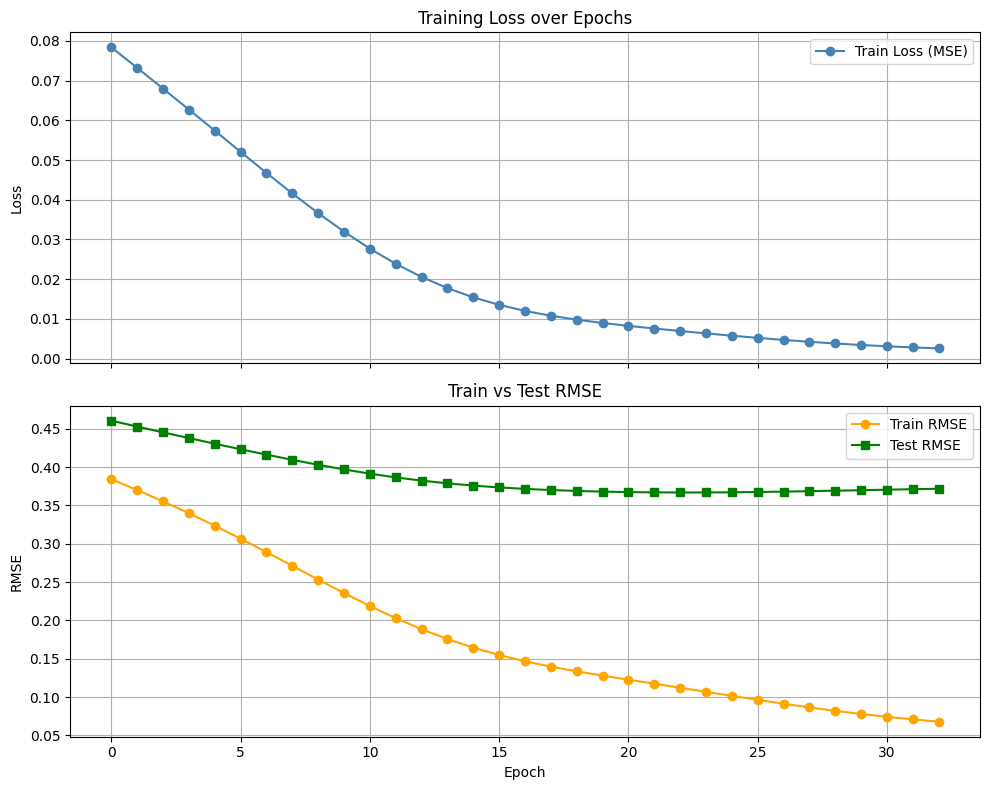


 Training completed. Best Test RMSE: 0.366783 at epoch 23.


In [23]:
# Best model form grid search
history, X_hat, X_hat_softmax, best_rmse, best_epoch = train_and_evaluate(
    X_train, train_mask, test_idx, test_ratings,
    k=20, epochs=300, lr=1e-2, loss_type="huber", l2_lambda=5e-4,
    plot=True)

### Final result visualization

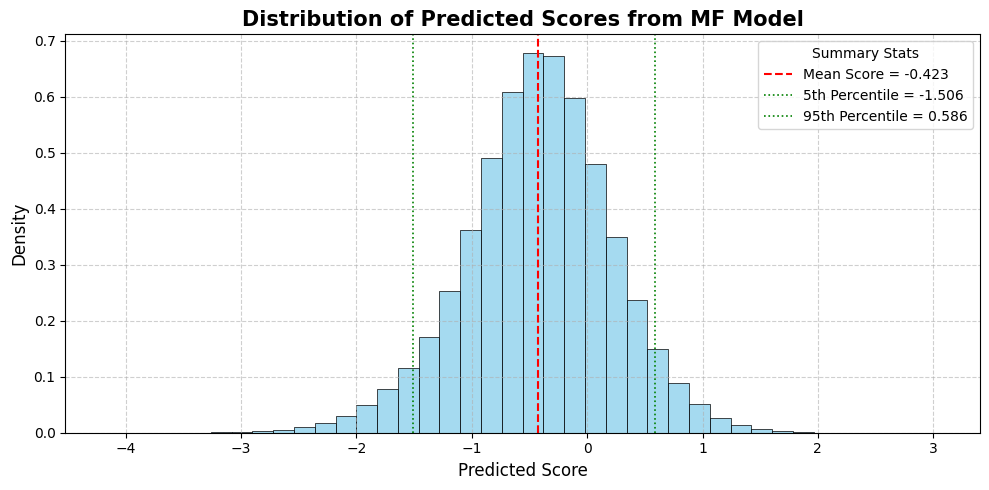

In [24]:
score_matrix = X_hat.cpu().numpy().flatten()
mean_pred = np.mean(score_matrix)
p5, p95 = np.percentile(score_matrix, [5, 95])

plt.figure(figsize=(10, 5))
sns.histplot(score_matrix, bins=40, kde=False, color="skyblue", stat="density", edgecolor="black", linewidth=0.5)

# scratch line
plt.axvline(mean_pred, color="red", linestyle="--", linewidth=1.5, label=f"Mean Score = {mean_pred:.3f}")
plt.axvline(p5, color="green", linestyle=":", linewidth=1.2, label=f"5th Percentile = {p5:.3f}")
plt.axvline(p95, color="green", linestyle=":", linewidth=1.2, label=f"95th Percentile = {p95:.3f}")

#Label
plt.title("Distribution of Predicted Scores from MF Model", fontsize=15, fontweight='bold')
plt.xlabel("Predicted Score", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.legend(title="Summary Stats", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()